In [34]:
from himalaya.kernel_ridge import KernelRidgeCV
import os
import json
import numpy as np
#from himalaya.utils import load_hdf5_array
from config.dir import DATA_DIR, EM_DATA_DIR ,REPO_DIR
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.utils import generate_leave_one_run_out
from sklearn.model_selection import check_cv

# Using a single session as a training 

In [42]:
subject = "sub-UTS02"
dir ='results/eng1000'
file_name = os.path.join(REPO_DIR, dir,subject,'features.json')
with open(file_name, "r") as f:
	X_train = json.load(f)
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_train, dtype=float)
#X_train = np.vstack((X_train, X_train))
print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3705, 985)
(n_samples_test, n_features) = (3705, 985)


# Subject 2 for training and 3 for testing

In [ ]:
#subject = "sub-UTS01"
subject = "sub-UTS02"
subject_test = "sub-UTS03"
dir ='results/eng1000/'
with open(os.path.join(REPO_DIR, dir,subject,'fmri.json'), "r") as f:
	Y_train = json.load(f)

with open(os.path.join(REPO_DIR, dir,subject_test,'fmri.json'), "r") as f:
	Y_test = json.load(f)
Y_train = np.array(Y_train, dtype=float)
Y_train =np.pad(Y_train, [(0, 0), (0, 94251-81126)], mode='constant')
Y_test = np.array(Y_test, dtype=float)
print("(n_samples_train, n_voxels) =", Y_train.shape)
print("( n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3705, 107376)
( n_samples_test, n_voxels) = (1824, 94251)


In [45]:
with open(os.path.join(REPO_DIR, dir,subject,'run_on.json'), "r") as f:
	run_onsets = json.load(f)
run_onsets

[326, 569, 895, 1192, 1517, 1824, 1994, 2403, 2640, 2889, 3216]

In [46]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [47]:
X_train_= X_train.astype("float32")
alphas = np.logspace(1, 20, 20)

# Create training model pipline 

In [48]:
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

In [49]:
_ = pipeline.fit(X_train, Y_train)

# Scores of training and testing data set

In [50]:
scores_train = pipeline.score(X_train, Y_train)
print("(n_voxels train,) =", scores_train.shape)
#scores_test = pipeline.score(X_test, Y_test)
#print("(n_voxels test,) =", scores_test.shape)

(n_voxels train,) = (107376,)


/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/himalaya/scoring.py:61: RuntimeWarning: invalid value encountered in divide
  r2 = 1. - error / var


In [51]:
print("r-squared_average train =", np.mean(scores_train).round(4))
#print("r-squared_average =", np.mean(scores_test).round(6))

r-squared_average train = 0.0116


In [ ]:
backend = set_backend("torch_cuda", on_error="warn")
scores_test = backend.to_numpy(scores_test)

/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


<Axes: xlabel='log10(alpha)', ylabel='Number of targets'>

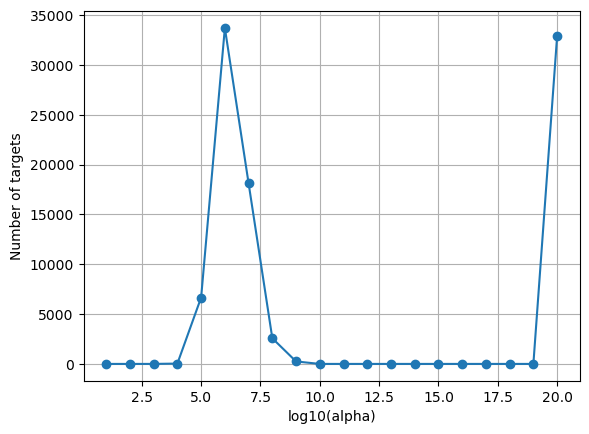

In [19]:
from himalaya.viz import plot_alphas_diagnostic
best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
#plt.show()

In [20]:
primal_coef = pipeline[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_delays * n_features, n_voxels) =", primal_coef.shape)

(n_delays * n_features, n_voxels) = (3940, 94251)


In [21]:
primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]
primal_coef *= np.sqrt(np.maximum(0, scores_test))[None]

In [22]:
# split the ridge coefficients per delays
delayer = pipeline.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)
del primal_coef

# average over delays
average_coef = np.mean(primal_coef_per_delay, axis=0)
print("(n_features, n_voxels) =", average_coef.shape)
del primal_coef_per_delay

(n_delays, n_features, n_voxels) = (4, 985, 94251)
(n_features, n_voxels) = (985, 94251)


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(average_coef.T)
components = pca.components_
print("(n_components, n_features) =", components.shape)

(n_components, n_features) = (4, 985)


In [24]:
print("PCA explained variance =", pca.explained_variance_ratio_)

PCA explained variance = [0.18034443 0.15147918 0.07549113 0.06679695]


In [ ]:
# transform with the fitted PCA
average_coef_transformed = pca.transform(average_coef.T).T
print("(n_components, n_voxels) =", average_coef_transformed.shape)
del average_coef

# We make sure vmin = -vmax, so that the colormap is centered on 0.
vmax = np.percentile(np.abs(average_coef_transformed), 99.9)

# plot the primal weights projected on the first principal component.
ax = plot_flatmap_from_mapper(average_coef_transformed[0], mapper_file,
                              vmin=-vmax, vmax=vmax, cmap='coolwarm')
plt.show()